In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load the banknote data into a pandas dataframe
fname = r'banknote.data.txt'
bnote = pd.read_csv(fname,header=None)
# peak at the first five rows
bnote.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


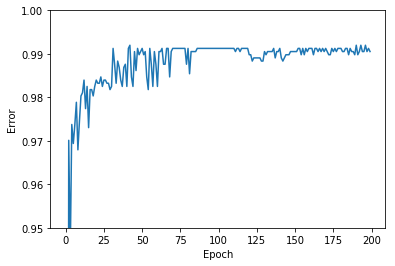

In [277]:
X = bnote.iloc[:,:-1]
y = 2*bnote.iloc[:,-1]-1

# we generate a hyperplane using the perceptron algorithm, recycled from pset 3, it works
nx = np.size(X,1)+1
ny = np.size(X,0)
X0 = np.hstack((X,-np.ones((ny,1))))
X0[y<0,] = -X0[y<0,]
w = np.zeros((nx))
y_est = np.squeeze(np.matmul(X0,w))>0
lpcnt = 0
T = 200
acchist = np.zeros((T))
while sum(y_est)<ny and lpcnt<T:
    y_est = np.matmul(X0,w)>=1
    acchist[lpcnt] = sum(y_est)/ny
    lpcnt+=1
    i = 0
    while i<ny:
        y_est[i] = np.matmul(X0[i,],w)>=1
        if y_est[i]<=0:
            w+=X0[i,]/np.linalg.norm(X0[i,])
        i+=1
plt.plot(acchist)
plt.ylim((0.95,1))
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

We find that the perceptron algorithm never converged and the accuracy stalled near 0.99. This suggests that the problem is likely not linearly seperable

b) now we directly optimize **(3)**

In [291]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
lb = np.linspace(1, 10, num=20)
Q = matrix(np.vstack([np.hstack([np.eye(nx),np.zeros((nx,ny))]),np.zeros((ny,nx+ny))]))
G = matrix(np.vstack([np.hstack([-X0,-np.eye(ny)]),np.hstack([np.zeros((ny,nx)),-np.eye(ny)])]))
h = matrix(np.vstack([np.ones((ny,1)),np.zeros((ny,1))]))

acc = np.zeros(len(lb))
ws = np.zeros((nx,len(lb)))
for i,l in enumerate(lb):
    p = matrix(np.vstack([np.zeros((nx,1)),l*np.ones((ny,1))]))
    sol=solvers.qp(Q, p, G, h)
    wi = np.asarray(sol['x'][:nx]).squeeze()
    y_est = np.matmul(X0,wi)>=0
    acc[i] = sum(y_est)/ny
    ws[:,i] = wi

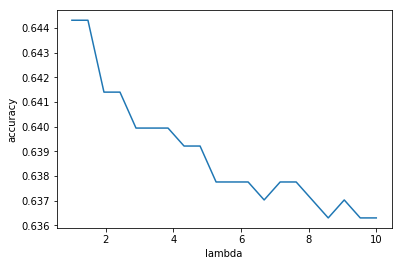

In [293]:
plt.plot(lb,acc)
plt.ylabel('accuracy')
plt.xlabel('lambda')
plt.show()

In [298]:
print('The best accuracy from using cvxopt is {:0.2f} with lambda of {:0.2f}'.format(np.max(acc),lb[np.argmax(acc)]))

The best accuracy from using cvxopt is 0.64 with lambda of 1.00


The plot is very flat as a function of $\lambda$ This is likele due to the fact that only a few points will contribute to the value of the second sum(see below). This value is actually very bad compared to the result from boosting which is not what I would expect. I have likely made a mistake here.

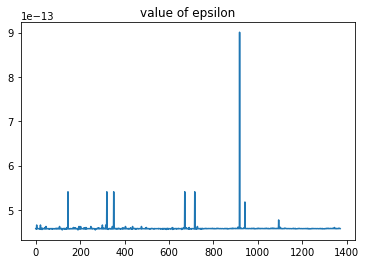

In [303]:
plt.plot(np.asarray(sol['x'][nx:]).squeeze())
plt.title('value of epsilon')
plt.show()

c) Now switch to subgradient descent on objective **(4)**. The accuracy is also around 99%.

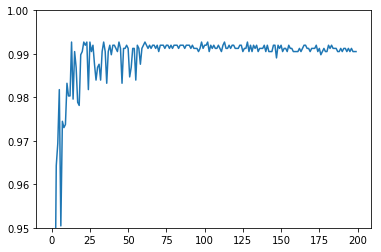

In [337]:
def subgrad(w_curr,l_opt):
    wsg = w_curr
    for i in range(ny):
        if 1-np.matmul(X0[i,:],w_curr)>0:
            wsg+=l_opt*X0[i,:].T
    return wsg
alpha = 1e-10
T = 200
w = np.ones((nx,T))
acc_gd = np.zeros(T)
acc_gd[0] = sum(np.matmul(X0,w[:,0])>0)/ny
for t in range(T-1):
    dw = -alpha*subgrad(w[:,t],1)#np.matmul(X.T,np.matmul(X,w[:,t])-Y)/n
    w[:,t+1] = w[:,t] + dw
    acc_gd[t+1] = sum(np.matmul(X0,w[:,t+1])>=1)/ny
plt.plot(acc_gd)
plt.ylim((.95,1))
plt.show()

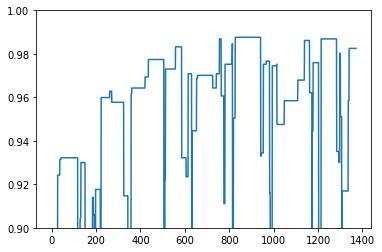

In [344]:
alpha = 1e-4
T = ny
w = np.ones((nx,T))
acc_sgd = np.zeros(T)
acc_sgd[0] = sum(np.matmul(X0,w[:,0])>0)/ny
for t in range(T-1):
    wsg = w[:,t]
    i = np.random.randint(ny)
    if 1-np.matmul(X0[i,:],w[:,t])>0:
        wsg+=1*X0[i,:].T
    dw = -alpha*wsg
    w[:,t+1] = w[:,t] + dw
    acc_sgd[t+1] = sum(np.matmul(X0,w[:,t+1])>=0)/ny
plt.plot(acc_sgd)
plt.ylim((.9,1))
plt.show()

A single pass through the data can get us something close to the performance of subgradient descent.